In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cPickle
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.models import load_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [3]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = cPickle.load(file)

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [4]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return (x - x.min()) / (x.max() - x.min())

In [5]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    one_hot_encode = np.array(np.zeros([len(x), 10]))
    index = 0
    for elements in x:
        one_hot_encode[index][elements] = 1
        index +=1
    return one_hot_encode

In [6]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    cPickle.dump((features, labels), open(filename, 'wb'))

In [7]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features,
            labels,
            'preprocess_batch_' + str(batch_i) + '.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = cPickle.load(file)

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [8]:
def load_preprocess_training(batch_id):
    """
    Load the Preprocessed Training data and return them
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = cPickle.load(open(filename, mode='rb'))

    # Return the training data
    return features, labels

In [9]:
# Preprocess the data with normalization and one hot encoding and save as .p file
# I have already preprocessed and saved the data, so no need to process and save again. Uncomment the following line if you want to test.
# preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [10]:
# Load the previous prepocessed and saved data
n_batches = 5
x_train, y_train = load_preprocess_training(1)

for batch_i in range(2, n_batches + 1):
    x, y = load_preprocess_training(batch_i)
    x_train = np.concatenate((x_train, x), axis=0)
    y_train = np.concatenate((y_train, y), axis=0)

In [11]:
model = Sequential()

model.add(Conv2D(32, (7, 7), input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
__________

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# The integrated load_data function is faster than my own implementation before. So I am using cifar10.load_data() to save some loading time.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
train_features = train_features/255.0
test_features = test_features/255.0
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [14]:
history = model.fit(train_features, train_labels,
                    batch_size=64,
                    epochs=10,
                    validation_data=(test_features, test_labels),
                    verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 536s 11ms/step - loss: 1.6664 - acc: 0.4406 - val_loss: 1.7632 - val_acc: 0.4742
Epoch 2/10
50000/50000 [==============================] - 534s 11ms/step - loss: 1.1087 - acc: 0.6099 - val_loss: 2.3690 - val_acc: 0.4614
Epoch 3/10
50000/50000 [==============================] - 531s 11ms/step - loss: 0.9196 - acc: 0.6774 - val_loss: 0.9270 - val_acc: 0.6796
Epoch 4/10
50000/50000 [==============================] - 531s 11ms/step - loss: 0.7988 - acc: 0.7219 - val_loss: 0.8701 - val_acc: 0.6944
Epoch 5/10
50000/50000 [==============================] - 533s 11ms/step - loss: 0.7219 - acc: 0.7489 - val_loss: 0.9206 - val_acc: 0.6851
Epoch 6/10
50000/50000 [==============================] - 531s 11ms/step - loss: 0.6495 - acc: 0.7737 - val_loss: 0.7147 - val_acc: 0.7546
Epoch 7/10
50000/50000 [==============================] - 530s 11ms/step - loss: 0.5923 - acc: 0.7931 - val_loss: 0.

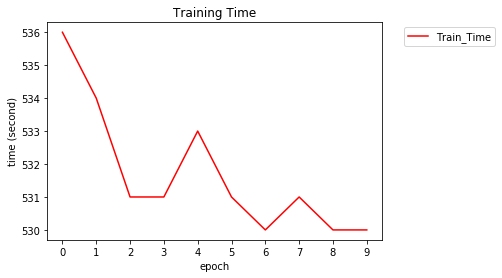

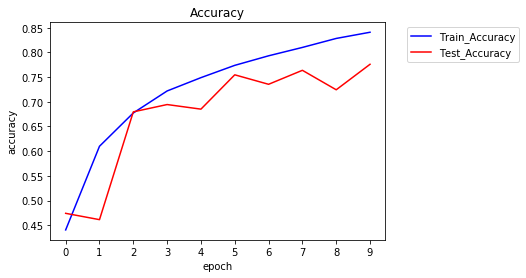

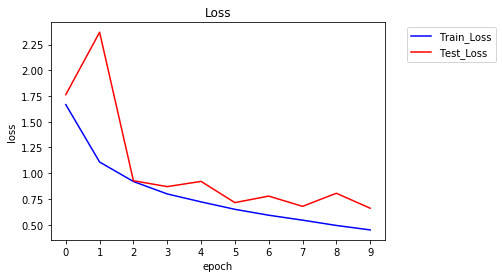

In [15]:
training_time = [536,534,531,531,533,531,530,531,530,530]
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('Training Time')
plt.plot(range(len(training_time)), training_time, 'r', label = 'Train_Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('time (second)')
plt.xlabel('epoch')
plt.xticks(range(10))
plt.figure()
plt.title('Accuracy')
plt.plot(range(len(acc)), acc, 'b', label = 'Train_Accuracy')
plt.plot(range(len(val_acc)), val_acc, 'r', label = 'Test_Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(10))
plt.figure()
plt.title('Loss')
plt.plot(range(len(loss)), loss, 'b', label = 'Train_Loss')
plt.plot(range(len(val_loss)), val_loss, 'r', label = 'Test_Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(10))
plt.show()

In [16]:
# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

In [17]:
# Returns a compiled model identical to the previous one
model = load_model('my_model.h5')

In [18]:
scores = model.evaluate(test_features, test_labels, verbose=1)

10000/10000 [==============================] - 35s 4ms/step


In [19]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.660337433195
Test accuracy: 0.7759
